# Mobile Games A/B Testing with Cookie Cats
---
This project is from a DataCamp project: https://www.datacamp.com/projects/184.

## Problem Statement
---
Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It is a classic "connect three" style puzzle game where the player must connect tiles of the same color in order to clear the board and win the level. As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention.

### Contents:
- [1. Data Collection](#1.-Data-Collection)
- [2. Data Cleaning and EDA](#2.-Data-Cleaning-and-EDA)
- [3. Pre-processing and Modeling](#3.-Pre-processing-and-Modeling)
- [4. Evaluation and Conceptual Understanding](#4.-Evaluation-and-Conceptual-Understanding)
- [5. Conclusion and Recommendations](#5.-Conclusion-and-Recommendations)

## 1. Data Collection
---
The dataset contains information on player rentention of a split test where the first gate in Cookie Cats was moved from level 30 to level 40. A total of 90,189 players installed the game while the A/B test was running. The variables are:

Feature|Type|Description
---|---|---
**userid**|_id_|A unique number that identifies each player.
**version**|_string_|Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).
**sum_gamerounds**|_integer_|The number of game rounds played by the player during the first 14 days after install.
**retention_1**|_boolean_|Did the player come back and play 1 day after installing?
**retention_7**|_boolean_|Did the player come back and play 7 days after installing?

## 2. Data Cleaning and EDA
---

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pymc3 as pm

sns.set(context='talk', palette='Set2')
%matplotlib inline

In [3]:
# Load raw data
df = pd.read_csv('./data/cookie_cats.csv')

In [83]:
# Print first 5 rows of data
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [84]:
# Check data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
userid            90189 non-null int64
version           90189 non-null object
sum_gamerounds    90189 non-null int64
retention_1       90189 non-null bool
retention_7       90189 non-null bool
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [139]:
# Number of players in each A/B group
df.version.value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

Text(0, 0.5, 'Number of game rounds')

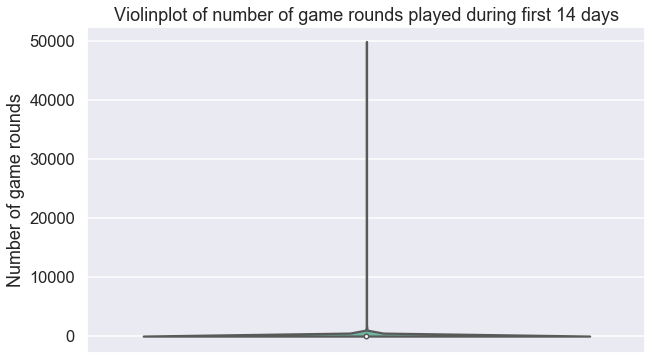

In [120]:
# Distribution of game rounds
plt.figure(figsize=(10,6))
ax = sns.violinplot(y='sum_gamerounds', data=df)
ax.set_title('Violinplot of number of game rounds played during first 14 days')
ax.set_ylabel('Number of game rounds')

In [87]:
# Descriptive statistics of game rounds 
df.sum_gamerounds.describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

Text(0.5, 1.0, 'Game rounds played during first 14 days')

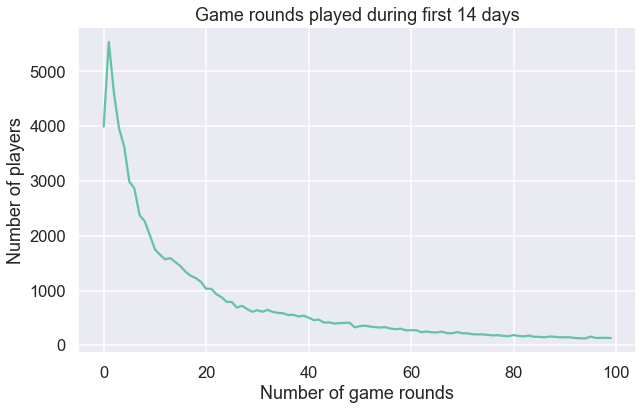

In [136]:
# Plot distribution of game rounds
df_plot = df.groupby('sum_gamerounds').count().reset_index()
plt.figure(figsize=(10,6))
ax = sns.lineplot(x='sum_gamerounds', y='userid', data=df_plot.head(n=100))
ax.set_xlabel('Number of game rounds')
ax.set_ylabel('Number of players')
ax.set_title('Game rounds played during first 14 days')

In [89]:
# Overall 1-day retention
df.retention_1.mean()

0.4452095044850259

In [90]:
# 1-day retention by A/B group
df.groupby('version')['retention_1'].mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

In [91]:
# Overall 7-day retention
df.retention_7.mean()

0.1860648194347426

In [92]:
# 7-day retention by A/B group
df.groupby('version')['retention_7'].mean()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

## 3. Pre-processing and Modeling
---

### a. Chi-squared test for A/B testing

Null hypothesis: The retention rate is the same for the two versions.

Alternative hypothesis: The retention rate is higher for the gate at level 30.

In [54]:
# Set up contingency table
df_con = pd.DataFrame(data={'version': ['gate_30', 'gate_40']})
df_con['retained_1'] = df[df.retention_1==True].groupby(by='version').count()['retention_1'].values
df_con['nonretained_1'] = df[df.retention_1==False].groupby(by='version').count()['retention_1'].values
df_con['retained_7'] = df[df.retention_7==True].groupby(by='version').count()['retention_7'].values
df_con['nonretained_7'] = df[df.retention_7==False].groupby(by='version').count()['retention_7'].values

In [67]:
# Chi-squared test for 1-day retention
chi2, pvalue, _, _ = stats.chi2_contingency(df_con[['retained_1', 'nonretained_1']])
print('Test statistic: {}\np-value: {}'.format(chi2, pvalue))

Test statistic: 3.1591007878782262
p-value: 0.07550476210309086


In [65]:
# Chi-squared test for 7-day retention
chi2, pvalue, _, _ = stats.chi2_contingency(df_con[['retained_7', 'nonretained_7']])
print('Test statistic: {}\np-value: {}'.format(chi2, pvalue))

Test statistic: 9.959086799559165
p-value: 0.0016005742679058301


### b. Bayesian A/B testing

#### Difference in 1-day retention

In [106]:
# Set up a pymc3 model and uniform priors for the probabilities of retention for arms A and B
with pm.Model() as day1_model:
    A_p = pm.Uniform('A_prob', lower=0, upper=1)
    B_p = pm.Uniform('B_prob', lower=0, upper=1)

In [107]:
# Set up pm.Bernoulli distributions to model retentions for arms A and B
with day1_model:
    A = pm.Bernoulli('A', p=A_p, observed=df[df.version == 'gate_30'].retention_1.values)
    B = pm.Bernoulli('B', p=B_p, observed=df[df.version == 'gate_40'].retention_1.values)
    AvB = pm.Deterministic('AvB', A_p - B_p)

In [122]:
# Fit the model
with day1_model:
    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [B_prob, A_prob]
Sampling 4 chains: 100%|█████████████████████████████████████████████████████| 22000/22000 [00:31<00:00, 702.70draws/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002A4F8252948>,
      dtype=object)

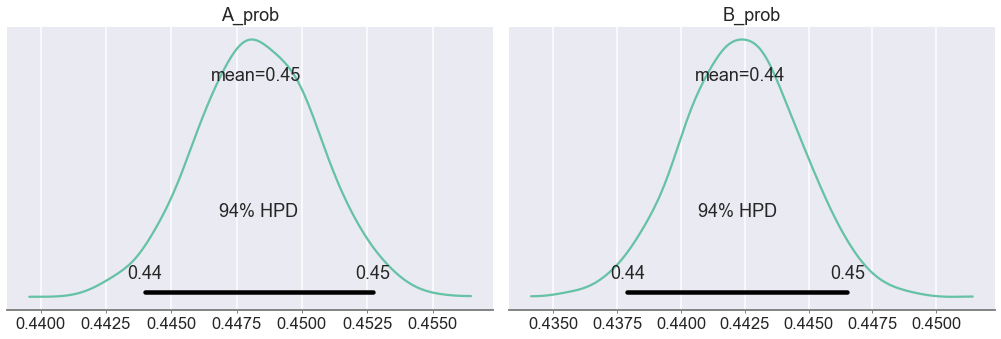

In [124]:
# Plot posterior densities for arms A and B
pm.plot_posterior(trace[::3], var_names=['A_prob', 'B_prob'])

In [125]:
def plot_betas(beta_traces, beta_names, colors=['steelblue','darkred']):
    fig, ax = plt.subplots(figsize=(9,5))
    for i, bn in enumerate(beta_names):
        ax = sns.distplot(beta_traces[i], kde=True, color=colors[i], label=bn)
    ax.legend(loc='upper right')
    plt.show()

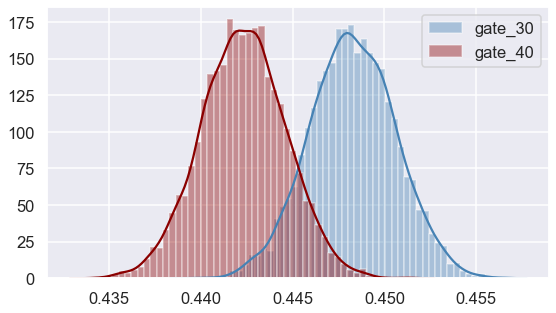

In [126]:
# Plot posterior densities for arms A and B together
plot_betas([trace[::3]['A_prob'], 
            trace[::3]['B_prob']],
            ['gate_30','gate_40'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002A4F3AB12C8>],
      dtype=object)

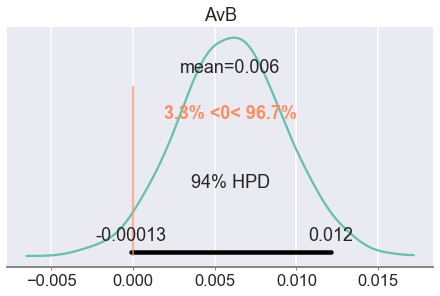

In [127]:
# Plot posterior density for differences with reference line
pm.plot_posterior(trace[::3], var_names='AvB', ref_val=0)

#### Difference in 7-day retention

In [128]:
# Set up a pymc3 model and uniform priors for the probabilities of retention for arms A and B
with pm.Model() as day7_model:
    A_p = pm.Uniform('A_prob', lower=0, upper=1)
    B_p = pm.Uniform('B_prob', lower=0, upper=1)

In [129]:
# Set up pm.Bernoulli distributions to model retentions for arms A and B
with day7_model:
    A = pm.Bernoulli('A', p=A_p, observed=df[df.version == 'gate_30'].retention_7.values)
    B = pm.Bernoulli('B', p=B_p, observed=df[df.version == 'gate_40'].retention_7.values)
    AvB = pm.Deterministic('AvB', A_p - B_p)

In [130]:
# Fit the model
with day7_model:
    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [B_prob, A_prob]
Sampling 4 chains: 100%|████████████████████████████████████████████████████| 22000/22000 [00:21<00:00, 1017.91draws/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002A4F5DA1CC8>,
      dtype=object)

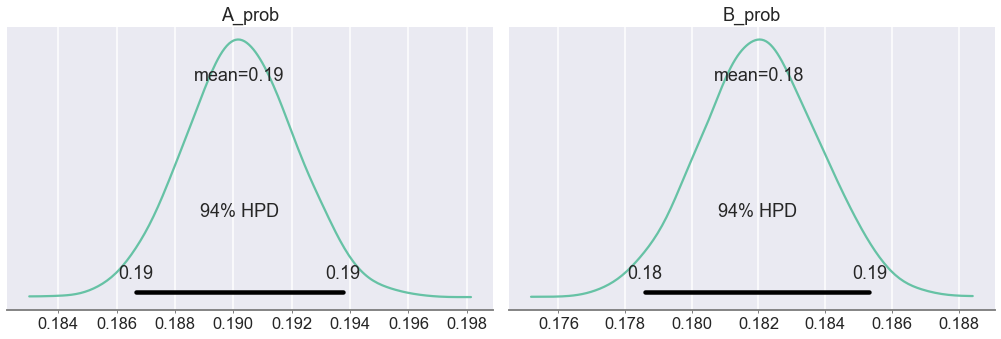

In [131]:
# Plot posterior densities for arms A and B
pm.plot_posterior(trace[::3], var_names=['A_prob', 'B_prob'])

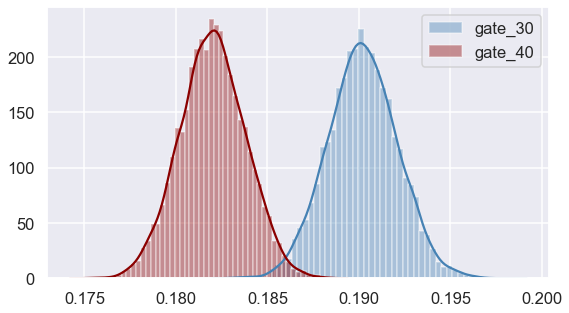

In [132]:
# Plot posterior densities for arms A and B together
plot_betas([trace[::3]['A_prob'], 
            trace[::3]['B_prob']],
            ['gate_30','gate_40'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002A4F664C1C8>],
      dtype=object)

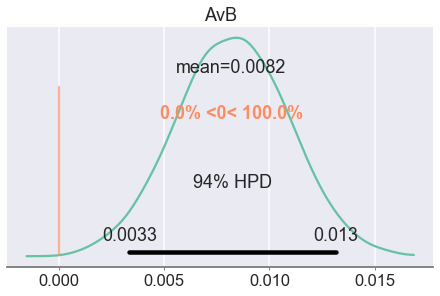

In [133]:
# Plot posterior density for differences with reference line
pm.plot_posterior(trace[::3], var_names='AvB', ref_val=0)

## 4. Evaluation and Conceptual Understanding
---
### 1-day retention

- There was a slight decrease in 1-day retention when the gate was moved from level 30 (44.8%) to level 40 (44.2%).
- However, according to our chi-squared test, there was no significant difference in retention rates between the two versions at the 5% significance level. We do not have enough evidence to reject our null hypothesis that retention rate is the same for the two versions.
- From our bayesian analysis, the probability that 1-day retention is greater when the gate is at level 30 is 96.7%.

### 7-day retention

- There was also a slight decrease in 7-day retention when the gate was moved from level 30 (19.0%) to level 40 (18.2%).
- According to our chi-squared test, there was a significant difference in retention rates at the 1% significance level. We reject our null hypothesis and accept our alternative hypothesis that 7-day retention rate is higher when the gate is at level 30.
- From our bayesian analysis, the probability that 7-day retention is greater when the gate is at level 30 is 100%.

## 5. Conclusion and Recommendations
---
- There is strong evidence that 7-day retention is higher when the first gate is at level 30 than when it is at level 40. We should not move the gate from level 30 to level 40.
- Close to 4,000 players (4.4%) did not play a single round after installation and more than 20,000 players (23%) played five rounds or less. We can try to collect player feedback, for example, through an in-app survey.